In [1]:
import casadi as ca
import matplotlib.pyplot as plt
import numpy as np

## MPC with Obstacle Avoidance Constraint

For obstacle avoidance, we add a mathematical inequality constraint to the optimization problem

Assuming the obstacle is modeled as a circular object, the Euclidean distance between the robot state $(x_k​,y_k​)$ and the obstacle center $(x_{obs}​,y_{obs}​)$ must be greater than a safe radius $r_{safe}$​. The safety radius is the sum of the obstacle's radius and the robot's own radius:

$$(x_k - x_{obs})^2 + (y_k - y_{obs})^2 \ge r_{safe}^2$$

$$r_{safe} = r_{obs} + r_{ego}$$

**Implementation in CasADi**

Since we are using standard solver (IPOPT) which typically expect constraints in the form $g(x) \leq 0$ or $L \leq g(x) \leq U$, we use the box inequality format:

$$
r_{safe}^2 \le (x_k - x_{obs})^2 + (y_k - y_{obs})^2 \le \infty
$$

In [2]:
N = 10
dt = 0.1
target = [10.0, 10.0, 0.0]
start = [0.0, 0.0, 0.0]

#### Single Obstacle

In [3]:
obs_x, obs_y = 5.0, 5.0
obs_radius = 1.0
ego_radius = 0.5
min_dist_sq = (obs_radius + ego_radius) ** 2  # Minimum squared distance allowed

#### Unicycle

In [4]:
x_sym = ca.SX.sym("x", 3)
u_sym = ca.SX.sym("u", 2)

rhs = ca.vertcat(u_sym[0] * ca.cos(x_sym[2]), u_sym[0] * ca.sin(x_sym[2]), u_sym[1])

x_next = x_sym + rhs * dt
unicycle = ca.Function("f", [x_sym, u_sym], [x_next])

#### Build Optimization Setup

In the code:

- `dist_to_obs` is the symbolic expression $(x_k - x_{obs})^2 + (y_k - y_{obs})^2$
- `lbg` (lower bound of constraint) is set to `min_dist_sq` ($r_{safe}^2$)
- `ubg` (upper bound) is set to $\infty$.

In [5]:
U = []  # Controls
J = 0  # Cost
g = []  # Constraints list (New for Obstacles)

w_goal = 10.0

P = ca.SX.sym("P", 3)
curr_state = P

for k in range(N):
    u_k = ca.SX.sym(f"U_{k}", 2)
    U.append(u_k)

    # Evolve State
    curr_state = unicycle(curr_state, u_k)

    # A. Cost: Goal Reaching
    dist_sq = (curr_state[0] - target[0]) ** 2 + (curr_state[1] - target[1]) ** 2
    J += dist_sq

    # B. Constraint: Obstacle Avoidance
    # Calculate distance to obstacle at this step
    # We are adding this expression to our list of constraints 'g'
    dist_to_obs = (curr_state[0] - obs_x) ** 2 + (curr_state[1] - obs_y) ** 2
    g.append(dist_to_obs)

# Terminal Cost
J += w_goal * ((curr_state[0] - target[0]) ** 2 + (curr_state[1] - target[1]) ** 2)

#### Solver Setup

In [6]:
OPT_variables = ca.vertcat(*U)
OPT_constraints = ca.vertcat(*g)  # Flatten constraint list

nlp_prob = {"f": J, "x": OPT_variables, "p": P, "g": OPT_constraints}

opts = {
    "ipopt.print_level": 0,
    "print_time": False,
    "ipopt.tol": 1e-4,
    "ipopt.warm_start_init_point": "yes",
}

solver = ca.nlpsol("solver", "ipopt", nlp_prob, opts)

#### Bounds

In [7]:
# Control Bounds
lbx = [-5, -2] * N
ubx = [5, 2] * N

# Constraint Bounds (The inequality)
# We want: dist_to_obs >= min_dist_sq
# So: min_dist_sq <= g <= infinity
lbg = [min_dist_sq] * N
ubg = [ca.inf] * N

# Initial guess
u_guess = [0] * (N * 2)

#### MPC 

In [8]:
curr_state_num = np.array(start, dtype=np.float64)
path_x = [start[0]]
path_y = [start[1]]

max_sim_step = 200

for t in range(max_sim_step):
    sol = solver(x0=u_guess, lbx=lbx, ubx=ubx, lbg=lbg, ubg=ubg, p=curr_state_num)

    u_opt = sol["x"].full().flatten()

    # Extract first control
    v_cmd = u_opt[0]
    w_cmd = u_opt[1]

    # Warm Start
    u_guess = np.concatenate((u_opt[2:], [0, 0]))

    # Simulate
    theta = curr_state_num[2]
    curr_state_num[0] += v_cmd * np.cos(theta) * dt
    curr_state_num[1] += v_cmd * np.sin(theta) * dt
    curr_state_num[2] += w_cmd * dt

    path_x.append(curr_state_num[0])
    path_y.append(curr_state_num[1])

    if (
        np.sqrt(
            (curr_state_num[0] - target[0]) ** 2 + (curr_state_num[1] - target[1]) ** 2
        )
        < 0.2
    ):
        print(f"Target Reached at step {t}!")
        break


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Target Reached at step 28!


#### Plot

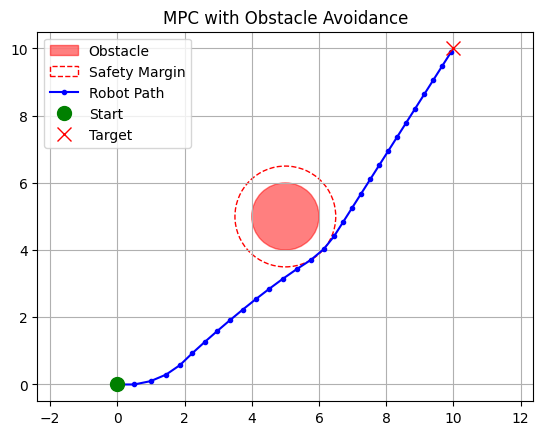

In [9]:
plt.figure()

# Plot Obstacle
circle = plt.Circle((obs_x, obs_y), obs_radius, color="r", alpha=0.5, label="Obstacle")
plt.gca().add_patch(circle)

# Plot Safety Margin
circle_safe = plt.Circle(
    (obs_x, obs_y),
    obs_radius + ego_radius,
    color="r",
    fill=False,
    linestyle="--",
    label="Safety Margin",
)
plt.gca().add_patch(circle_safe)

plt.plot(path_x, path_y, "b-o", markersize=3, label="Robot Path")
plt.plot(start[0], start[1], "go", markersize=10, label="Start")
plt.plot(target[0], target[1], "rx", markersize=10, label="Target")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.title("MPC with Obstacle Avoidance")
plt.show()